In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
user_rating_data = pd.read_table('data/u.data.txt',na_values=['?'],delimiter="\t",header=None )

In [3]:
user_rating_data.columns = ['user_id','item_id','rating','timestamp']


In [4]:
# Display the data

user_rating_data.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
#Shape of the data
user_rating_data.shape

(100000, 4)

In [6]:
#Taking subset of the dataset
#user_rating_data=user_rating_data.iloc[:24482,0:]

In [7]:
user_rating_data

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [8]:
#Check the datatypes
user_rating_data.dtypes

user_id      int64
item_id      int64
rating       int64
timestamp    int64
dtype: object

In [9]:
user_rating_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [10]:
#Five point summary 

user_rating_data.describe()['rating']

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [11]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(user_rating_data.rating.min()))
print('Maximum rating is: %d' %(user_rating_data.rating.max()))

Minimum rating is: 1
Maximum rating is: 5


In [12]:
#Check for missing values
print('Number of missing values across columns: \n',user_rating_data.isnull().sum())

Number of missing values across columns: 
 user_id      0
item_id      0
rating       0
timestamp    0
dtype: int64


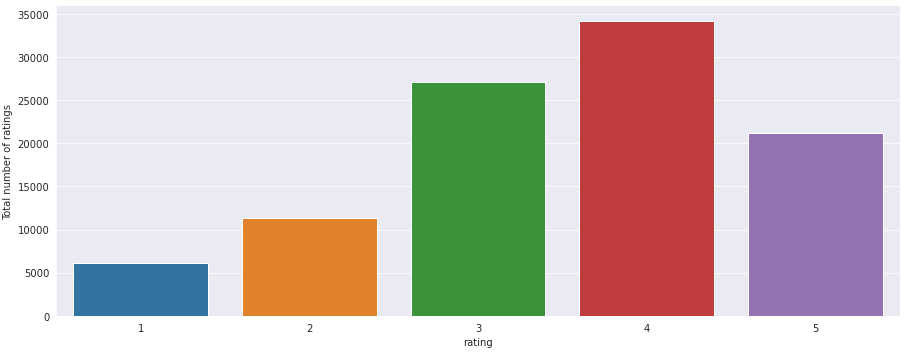

In [13]:
# Check the distribution of the rating
with sns.axes_style('darkgrid'):
    g = sns.factorplot("rating", data=user_rating_data, aspect=2.5,kind='count')
    g.set_ylabels("Total number of ratings")

In [55]:
print("Total data ")
print("-"*40)
print("\nTotal no of ratings :",user_rating_data.shape[0])
print("Total No of Users   :", len(np.unique(user_rating_data.user_id)))
print("Total No of Movies  :", len(np.unique(user_rating_data.item_id)))

Total data 
----------------------------------------

Total no of ratings : 100000
Total No of Users   : 943
Total No of Movies  : 1682


In [56]:
#Dropping the Timestamp column

user_rating_data.drop(['timestamp'], axis=1,inplace=True)

KeyError: "['timestamp'] not found in axis"

In [57]:
#Analysis of rating given by the user 

no_of_rated_movies_per_user = user_rating_data.groupby(by='user_id')['rating'].count().sort_values(ascending=False)

no_of_rated_movies_per_user.head()

user_id
405    737
655    685
13     636
450    540
276    518
Name: rating, dtype: int64

In [58]:
no_of_rated_movies_per_user.describe()

count    943.000000
mean     106.044539
std      100.931743
min       20.000000
25%       33.000000
50%       65.000000
75%      148.000000
max      737.000000
Name: rating, dtype: float64

In [62]:
min_rating_count = no_of_rated_movies_per_user.min()
print(' min_rating_count ',min_rating_count)

 min_rating_count  20


In [35]:
no_of_rated_movies_per_user.index

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

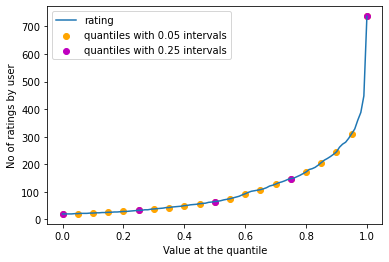

In [131]:
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [18]:
f = ['count','mean']

df_movie_summary = user_rating_data.groupby('item_id')['rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = user_rating_data.groupby('user_id')['rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 65.0
Customer minimum times of review: 127.0


In [19]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

In [20]:
quantiles

0.00     20
0.01     20
0.02     20
0.03     20
0.04     21
       ... 
0.96    328
0.97    360
0.98    388
0.99    448
1.00    737
Name: rating, Length: 101, dtype: int64

In [21]:
quantiles.values[::5]

array([ 20,  21,  23,  26,  29,  33,  38,  43,  50,  57,  65,  75,  93,
       108, 128, 148, 172, 206, 245, 311, 737], dtype=int64)

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

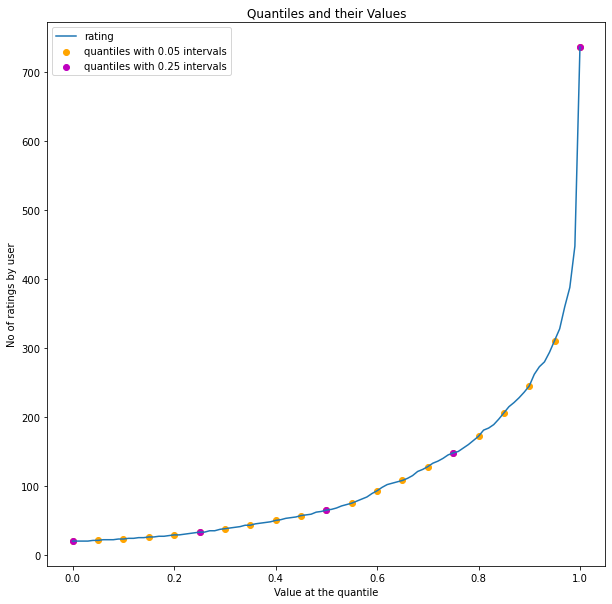

In [22]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [63]:
print(' min_rating_count ', min_rating_count)

 min_rating_count  20


In [65]:
print('\n No of rated movies more than {} per user : {}\n'.format(min_rating_count, sum(no_of_rated_movies_per_user >= min_rating_count)) )


 No of rated movies more than 20 per user : 943



In [70]:
#Getting the new dataframe which contains users who has given more than the 'min_rating_count' ratings

new_df=user_rating_data.groupby("item_id").filter(lambda x:x['rating'].count() >min_rating_count)
print(new_df.shape)

(94728, 3)


In [71]:
new_df.head()

,user_id,item_id,rating
0,196,242,3
1,186,302,3
3,244,51,2
4,166,346,1
5,298,474,4


In [99]:
no_of_ratings_per_movie = new_df.groupby(by='item_id')['rating'].count().sort_values(ascending=False)
print(no_of_ratings_per_movie)

item_id
50      583
258     509
100     508
181     507
294     485
       ... 
758      21
816      21
1203     21
795      21
1084     21
Name: rating, Length: 927, dtype: int64


Text(0.5, 1.0, '# RATINGS per Movie')

Text(0.5, 0, 'Movie')

Text(0, 0.5, 'No of ratings per Movie')

[]

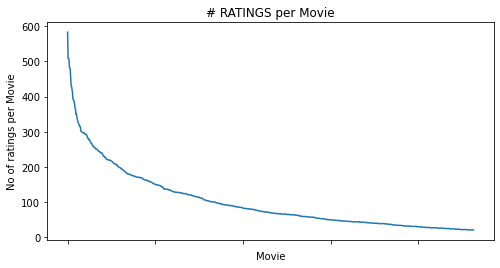

In [100]:
## plot number of ratings per movie
fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('# RATINGS per Movie')
plt.xlabel('Movie')
plt.ylabel('No of ratings per Movie')
ax.set_xticklabels([])

plt.show()

In [101]:
#Average rating of the movie (sorting in descending order)
new_df.groupby('item_id')['rating'].mean().sort_values(ascending=False).head()

item_id
408    4.491071
318    4.466443
169    4.466102
483    4.456790
114    4.447761
Name: rating, dtype: float64

In [102]:
#Total no of rating for movie  (sorting in descending order)

new_df.groupby('item_id')['rating'].count().sort_values(ascending=False).head()

item_id
50     583
258    509
100    508
181    507
294    485
Name: rating, dtype: int64

In [103]:
ratings_mean_count = pd.DataFrame(new_df.groupby('item_id')['rating'].mean())
ratings_mean_count.head()

,rating
item_id,
1,3.878319
2,3.206107
3,3.033333
4,3.550239
5,3.302326


In [104]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('item_id')['rating'].count())

In [105]:
ratings_mean_count.head()

,rating,rating_counts
item_id,,
1,3.878319,452
2,3.206107,131
3,3.033333,90
4,3.550239,209
5,3.302326,86


In [108]:
print("Max # of ratings ",ratings_mean_count['rating_counts'].max())

Max # of ratings  583


In [109]:
print("max avg rating ", ratings_mean_count['rating'].max())

max avg rating  4.491071428571429


<Figure size 576x432 with 0 Axes>

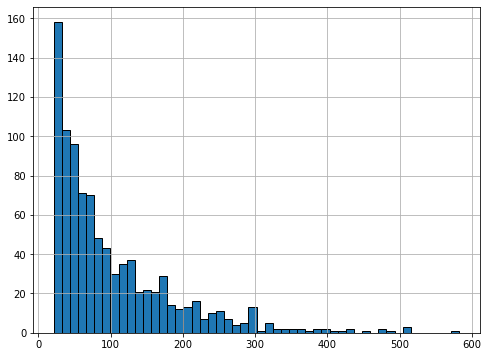

In [114]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

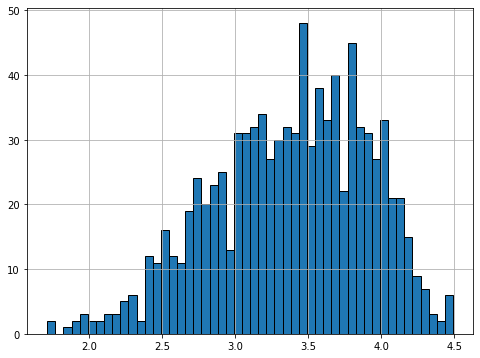

In [115]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

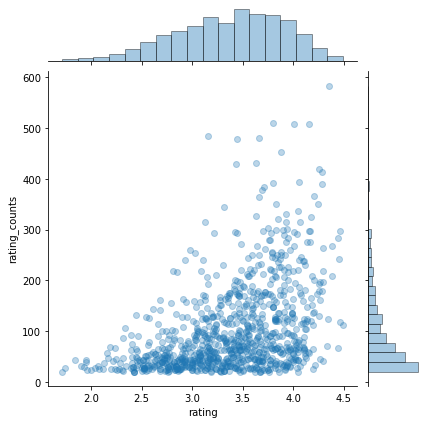

In [116]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='rating', y='rating_counts', data=ratings_mean_count, alpha=0.3)

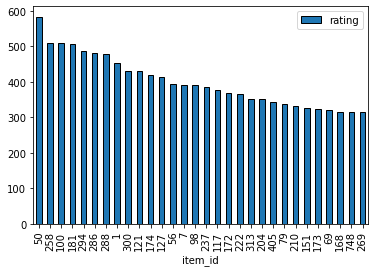

In [117]:
popular_movies = pd.DataFrame(new_df.groupby('item_id')['rating'].count())
most_popular = popular_movies.sort_values('rating', ascending=False)
most_popular.head(30).plot(kind = "bar")

## Collaberative filtering (Item-Item recommedation)
### Collaborative filtering is commonly used for recommender systems. These techniques aim to fill in the missing entries of a user-item association matrix. We are going to use collaborative filtering (CF) approach. CF is based on the idea that the best recommendations come from people who have similar tastes. In other words, it uses historical item ratings of like-minded people to predict how someone would rate an item.Collaborative filtering has two sub-categories that are generally called memory based and model-based approaches.

In [123]:
rating_class = new_df['rating']
vs_matrix = new_df.drop(['rating'],axis=1)
vs_matrix = new_df.copy()

In [124]:
rating_class

0        3
1        3
3        2
4        1
5        4
        ..
99995    3
99996    5
99997    1
99998    2
99999    3
Name: rating, Length: 94728, dtype: int64

In [125]:
vs_train, vs_test, vs_target_train, vs_target_test = train_test_split(vs_matrix,rating_class, test_size=0.2, random_state=33)


In [126]:
vs_train.head()

,user_id,item_id,rating
45799,276,355,3
3525,185,127,5
26120,474,234,5
38254,268,743,1
41878,44,163,4


In [127]:
from sklearn.cluster import KMeans

K = 7
kmean = KMeans(n_clusters=K);

kmean.fit(vs_train)
clusters = kmean.predict(vs_train)

pd.options.display.float_format='{:,.2f}'.format

centroids = pd.DataFrame(kmean.cluster_centers_, columns=vs_train.columns)
print(centroids)

KMeans(n_clusters=7)

   user_id  item_id  rating
0   256.47   533.88    3.60
1   782.73   178.87    3.65
2   153.84   179.50    3.69
3   717.86   908.85    3.20
4   266.49   913.54    3.19
5   451.53   183.91    3.67
6   715.84   529.79    3.52


In [128]:
pred_data = kmean.predict(vs_test)

In [129]:
## plot the silhouette
import pylab as pl
from sklearn.metrics import *
def plot_silhouettes(data, clusters, metric='euclidean'):
    
    from matplotlib import cm
    
    cluster_labels = np.unique(clusters)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(data, clusters, metric)
    c_ax_lower, c_ax_upper = 0, 0
    cticks = []
    for i, k in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[clusters == k]
        c_silhouette_vals.sort()
        c_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        pl.barh(range(c_ax_lower, c_ax_upper), c_silhouette_vals, height=1.0, 
                      edgecolor='none', color=color)

        cticks.append((c_ax_lower + c_ax_upper) / 2)
        c_ax_lower += len(c_silhouette_vals)
    
    silhouette_avg = np.mean(silhouette_vals)
    pl.axvline(silhouette_avg, color="red", linestyle="--") 

    pl.yticks(cticks, cluster_labels)
    pl.ylabel('Cluster')
    pl.xlabel('Silhouette coefficient')

    pl.tight_layout()
    #pl.savefig('images/11_04.png', dpi=300)
    pl.show()
    
    return

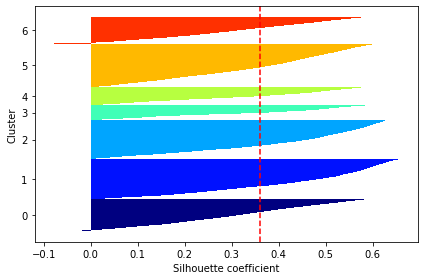

Wall time: 3min 19s


In [130]:
%%time
data_clu = np.array(vs_train)
plot_silhouettes(data_clu,clusters)

In [147]:
classes_arr = np.array(vs_target_train)
classes_arr

print("AGE - completeness_score : ",completeness_score(classes_arr,clusters))
print("AGE homogeneity_score : ",homogeneity_score(classes_arr,clusters))

array([3, 3, 4, ..., 5, 4, 5], dtype=int64)

AGE - completeness_score :  0.008311435097204032
AGE homogeneity_score :  0.010633981990341814


## Model-based collaborative filtering system
#### These methods are based on machine learning and data mining techniques. The goal is to train models to be able to make predictions. For example, we could use existing user-item interactions to train a model to predict the top-5 items that a user might like the most. One advantage of these methods is that they are able to recommend a larger number of items to a larger number of users, compared to other methods like memory based approach. They have large coverage, even when working with large sparse matrices.

In [148]:
new_df1=new_df.head(10000)
ratings_matrix = new_df1.pivot_table(values='rating', index='user_id', columns='item_id', fill_value=0)
ratings_matrix.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,1473,1478,1479,1480,1487,1489,1495,1503,1518,1529
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [149]:
ratings_matrix.shape

(386, 1192)

In [150]:
# transpose the matrix
X = ratings_matrix.T
X.head()


user_id,1,2,3,4,5,6,7,8,9,10,...,379,380,381,382,383,385,386,387,388,389
item_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,4,...,0,0,0,0,0,2,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
X.shape

(1192, 386)

In [74]:
X1 = X

In [75]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(1192, 10)

In [76]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape


(1192, 1192)

In [77]:
print("correlation_matrix range \n\t min = {} ,\n\t max = {} ,\n\t mean {}".format(correlation_matrix.min(),correlation_matrix.max(),correlation_matrix.mean()))

correlation_matrix range 
	 min = -0.8540340519964553 ,
	 max = 1.0 ,
	 mean 0.24811106441969108


In [78]:
X.index[602]

620

In [79]:
i = X.index[602]

movie_names = list(X.index)
item_id = movie_names.index(i)
item_id

602

### Correlation for all the movies watched by this user based on movies rated by other users people who saw the same movie

In [80]:
correlation_movie_ID = correlation_matrix[item_id]
correlation_movie_ID.shape

(1192,)

In [81]:
correlation_movie_ID

array([ 0.3819547 ,  0.3219768 ,  0.43270785, ..., -0.25167916,
        0.65877603, -0.19905241])

## Recommending top 25 highly correlated movies in sequence

In [92]:
item_data = pd.read_table('data/u.item.txt',na_values=['?'],delimiter="\t",header=None,encoding='latin-1')
item_data.columns = ['item_id','movie_title','release_date','video_release_date','IMDb_URL','unknown','Action','Adventure','Animation','Children\'s','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']
item_data.head()

,item_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,nan,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,nan,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,nan,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,nan,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,nan,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [93]:
movie_data = item_data[['item_id','movie_title']]
movie_data.head()

,item_id,movie_title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [100]:
uno = 250


df = user_rating_data.copy()
df_U = df[(df['user_id'] == uno) & (df['rating'] == 5)]
df_U = df_U.set_index('item_id')
df_U = df_U.join(movie_data)['movie_title']
df_U.columns = ['item_id','movie_title']
print(df_U)

item_id
596                                   Eraser (1996)
200                             Evil Dead II (1987)
64               What's Eating Gilbert Grape (1993)
480                           Apartment, The (1960)
92                  Welcome to the Dollhouse (1995)
71                                 Mask, The (1994)
969                             Hear My Song (1991)
813                   Great Day in Harlem, A (1994)
1137                                Best Men (1997)
474                            Trainspotting (1996)
135             Mr. Smith Goes to Washington (1939)
321                           Murder at 1600 (1997)
69               Four Weddings and a Funeral (1994)
50                       Legends of the Fall (1994)
501                                  Bananas (1971)
313     3 Ninjas: High Noon At Mega Mountain (1998)
676                     Fire on the Mountain (1996)
100                              Heavy Metal (1981)
993       Last Time I Committed Suicide, The (1997)
95  

In [ ]:
## Let's predict which movies user u would love to watch:

In [102]:
user_785314 = movie_data.copy()
user_785314 = user_785314.reset_index()
user_785314 = user_785314[~user_785314['item_id'].isin(drop_movie_list)]

# getting full dataset
data = user_rating_data[['user_id', 'item_id', 'rating']]

trainset = data.build_full_trainset()
svd.fit(trainset)

user_785314['Estimate_Score'] = user_785314['item_id'].apply(lambda x: svd.predict(785314, x).est)

user_785314 = user_785314.drop('item_id', axis = 1)

user_785314 = user_785314.sort_values('Estimate_Score', ascending=False)
print(user_785314.head(10))

AttributeError: 'DataFrame' object has no attribute 'build_full_trainset'

In [101]:
Recommend = list(X.index[correlation_movie_ID > 0.65])

# Removes the item already watched by the customer
Recommend.remove(i) 

Recommend[0:24]

[18,
 29,
 112,
 117,
 118,
 243,
 245,
 255,
 279,
 322,
 328,
 332,
 337,
 535,
 539,
 591,
 595,
 678,
 685,
 688,
 749,
 754,
 763,
 823]

### SVR

In [13]:
user_rating_data

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [15]:
dataset = user_rating_data.iloc[:, :-1]

In [16]:
dataset

,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
...,...,...,...
99995,880,476,3
99996,716,204,5
99997,276,1090,1
99998,13,225,2


In [32]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [33]:
y = y.reshape(len(y),1)

In [34]:
print(y)

[[3]
 [3]
 [1]
 ...
 [1]
 [2]
 [3]]


## Feature Scaling

In [35]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)

In [36]:
print(X)

[[-0.99951864 -0.55481245]
 [-1.03702618 -0.37343217]
 [-1.65214977 -0.14670681]
 ...
 [-0.69945835  2.00869557]
 [-1.68590655 -0.60620353]
 [-1.6896573  -0.67270964]]


In [37]:
print(y)

[[-0.47070718]
 [-0.47070718]
 [-2.24743003]
 ...
 [-2.24743003]
 [-1.35906861]
 [-0.47070718]]


## Training the SVR model on the whole dataset

In [ ]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X, y)

## Predicting a new result

In [ ]:
sc_y.inverse_transform(regressor.predict(sc_X.transform([[6.5]])))